
<h2 align=center> PLOTS - Named Entity Recognition (NER) using LSTMs with Keras</h2>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.3.0
GPU detected: []


In [15]:
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

In [6]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)

# Plot 1

In [43]:
table1 = data['Tag'].groupby(data['Tag']).agg(['count'])
table1 = table1.iloc[:-1,:]
table1 = table1.reset_index()
table1 

,Tag,count
0,B-art,402
1,B-eve,308
2,B-geo,37644
3,B-gpe,15870
4,B-nat,201
5,B-org,20143
6,B-per,16990
7,B-tim,20333
8,I-art,297
9,I-eve,253


In [45]:
import plotly.express as px

fig = px.histogram(table1, x="Tag",y="count",color="Tag",title="Count of Tag in NER dataset")
fig.show()

In [ ]:
import chart_studio
username = '' # medium username
api_key = '' # medium api key 
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)

In [36]:
import chart_studio.plotly as py
py.plot(fig, filename = 'NER_dataset', auto_open=True)

'https://plotly.com/~beiqizhou/42/'

# Plot 2


In [37]:
import tqdm
def sentence_integrate(data):
  agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
  return data.groupby('Sentence #').apply(agg_func).tolist()



In [38]:
sentences=sentence_integrate(data)

In [93]:
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

In [85]:
table2 = pd.DataFrame([len(s) for s in sentences])
table2 = table2.rename(columns={0: "length"})

In [90]:
fig1 = px.histogram(table2,x="length",marginal='box',title="Count of Sentence Lengths")
fig1.show()

In [91]:
import chart_studio.plotly as py
py.plot(fig1, filename = 'NER_sentence', auto_open=True)

'https://plotly.com/~beiqizhou/45/'

# Plot 3

In [95]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])

In [96]:
#split into test and train
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [97]:
#build model 
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import InputLayer, TimeDistributed, SpatialDropout1D, Bidirectional
from tensorflow import keras

In [98]:
model = keras.Sequential()
model.add(InputLayer((max_len)))
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add( Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 200)           120800    
Total params: 1,879,750
Trainable params: 1,879,750
Non-trainable params: 0
_________________________________________________________________


In [101]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

In [103]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

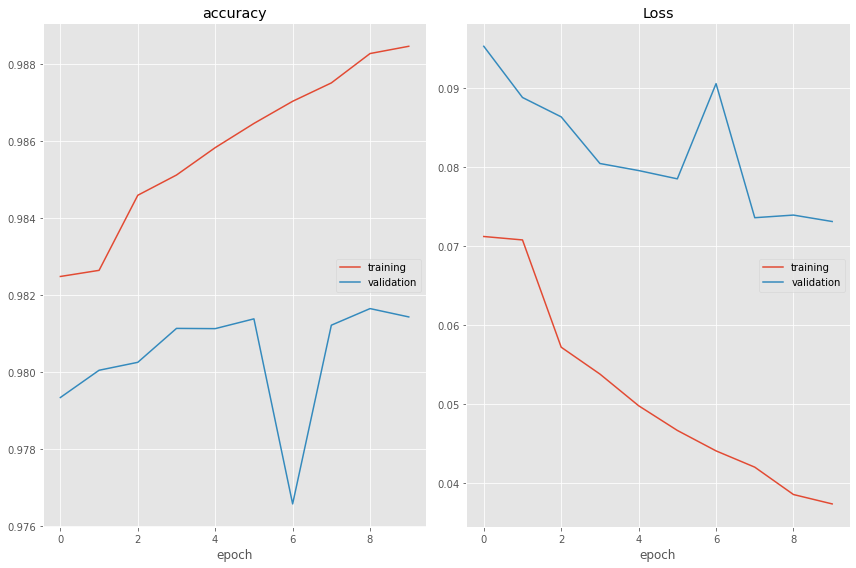

accuracy
	training         	 (min:    0.982, max:    0.988, cur:    0.988)
	validation       	 (min:    0.977, max:    0.982, cur:    0.981)
Loss
	training         	 (min:    0.037, max:    0.071, cur:    0.037)
	validation       	 (min:    0.073, max:    0.095, cur:    0.073)

Epoch 00010: val_loss improved from 0.07360 to 0.07312, saving model to model_weights.h5
1199/1199 [==============================] - 56s 46ms/step - loss: 0.0373 - accuracy: 0.9885 - val_loss: 0.0731 - val_accuracy: 0.9814
Wall time: 9min 12s


In [112]:
%%time

logdir="log/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

chkpt = ModelCheckpoint("model_weights.h5", monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=True, mode='min')

early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', baseline=None, restore_best_weights=False)

callbacks = [PlotLossesCallback(), chkpt, early_stopping,tensorboard_callback]


history = model.fit(
    x=x_train,
    y=y_train,
    validation_data=(x_test,y_test),
    batch_size=32, 
    epochs=10,
    callbacks=callbacks,
    verbose=1
    
)

In [118]:
table3 = pd.DataFrame(history.history)

table3 = table3.reset_index()
table3 = table3.rename(columns={"index": "epoches"})
table3

,epoches,loss,accuracy,val_loss,val_accuracy
0,0,0.071219,0.982486,0.095331,0.979339
1,1,0.070784,0.982646,0.088840,0.980048
2,2,0.057186,0.984598,0.086384,0.980254
3,3,0.053783,0.985125,0.080473,0.981136
4,4,0.049767,0.985837,0.079579,0.981130
5,5,0.046638,0.986466,0.078527,0.981385
6,6,0.044045,0.987042,0.090596,0.976572
7,7,0.041982,0.987520,0.073602,0.981220
8,8,0.038512,0.988284,0.073934,0.981651
9,9,0.037322,0.988472,0.073120,0.981435


In [135]:
y_accuracy = table3["accuracy"].to_list()
y_loss = table3["loss"].to_list()
y_val_loss = table3["val_loss"].to_list()
y_val_accuracy = table3["val_accuracy"].to_list()

x_value = table3["epoches"].to_list()

In [144]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig2 = make_subplots(rows=1, cols=2)

fig2.add_trace(
    go.Scatter(x=x_value, y=y_accuracy, name = "Accuracy"),
    row=1, col=1
)

fig2.add_trace(
    go.Scatter(x=x_value, y=y_val_accuracy, name = "Validation Accuracy"),
    row=1, col=1
   
)

fig2.add_trace(
    go.Scatter(x=x_value, y=y_loss, name = "Loss"),
    row=1, col=2
)

fig2.add_trace(
    go.Scatter(x=x_value, y=y_val_loss, name = "Validation Loss"),
    row=1, col=2
)


# Update xaxis properties
fig2.update_xaxes(title_text="Number of Epoches", row=1, col=1)
fig2.update_xaxes(title_text="Number of Epoches", row=1, col=2)


# Update yaxis properties
fig2.update_yaxes(title_text="Accuracy %", row=1, col=1)
fig2.update_yaxes(title_text="Loss %", row=1, col=2)


fig2.update_layout(height=500, width=800, title_text="Model's Accuracy and Loss")
fig2.show()


In [145]:
import chart_studio.plotly as py
py.plot(fig2, filename = 'NER_model', auto_open=True)

'https://plotly.com/~beiqizhou/48/'